<a href="https://colab.research.google.com/github/bhomaidan1990/Camera_Calibration/blob/master/HOG%2BSVM%2BFDDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computer Vision Course
Lab (2)

In [ ]:
##########################
# @Authors:              #
#     Belal Hmedan       #
# &   Junyi ZHONG        #
##########################
 
#========================
# Import Libraries
#========================
import os
import glob
import shutil
import re
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.patches import Rectangle
from keras.preprocessing import image
import cv2
import time
import math
import keras 
import tensorflow as tf
from keras import layers
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.decomposition import PCA
#--------------------------------------
# Run on GPU
#--------------------------------------
# Check if there is valid GPU to be used
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU")
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### 0-Reproducible Code Initialization

In [ ]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
# tf.random.set_seed(seed_value)
# for later versions: 
tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


### 1-Download the Dataset and related files

In [ ]:
#=======================
# Download the dataset
#=======================
# !rm -rf Dataset & rm -rf FDDB-folds & rm -rf sample_data & rm -rf NewDataset
!wget http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz
!wget http://vis-www.cs.umass.edu/fddb/FDDB-folds.tgz
#-----------------------
# Test_Data
#==================
!wget http://crowley-coutaz.fr/jlc/Courses/2020/GVR.VO/test_db.zip
!unzip test_db.zip &> /dev/null 
!mv TESTSET test &> /dev/null 
#-----------------------------------------------------------
# Extract the data
#==================
t0 = time.time()
!mkdir Dataset & 
!tar xvzf originalPics.tar.gz -C Dataset &> /dev/null
!tar xvzf FDDB-folds.tgz &> /dev/null
!rm originalPics.tar.gz & rm test_db.zip & rm FDDB-folds.tgz
t1 = time.time()
print('DeCompressing Time is : ',t1-t0," seconds")
# create the output dataset folder
!mkdir NewDataset

--2020-12-30 02:56:34--  http://vis-www.cs.umass.edu/fddb/originalPics.tar.gz
Resolving vis-www.cs.umass.edu (vis-www.cs.umass.edu)... 128.119.244.95
Connecting to vis-www.cs.umass.edu (vis-www.cs.umass.edu)|128.119.244.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 579061091 (552M) [application/x-gzip]
Saving to: ‘originalPics.tar.gz’

originalPics.tar.gz  92%[=================>  ] 513.16M  58.2MB/s    eta 1s     

### 2-Dataset Construction

**Building Indexed Data Structure for Accessing the Ground Truth easily.**

In [ ]:
#========================
# Paths Initialization
#========================
# Define the Path of the original FDDB, and the output path

datasetPath = "Dataset"
outPath     = "NewDataset"
 
# Specify The required folds
 
foldsPath = "FDDB-folds/"
#=======================
foldsList  = os.listdir(foldsPath)
foldsList.sort()
folds = foldsList[1::2] # Evens, image names
annot = foldsList[0::2] # Odds, annotaions
# print(folds, '\n \n ', annot)
#------------------------
# missed backgrounds
miss = 0
#------------------------
# Get Annotation Function
#========================
def getAnnot(imgName, annotPath):
    '''
    Function to get the annotations in nd-array format for a specified image.
    
    Parameters:
    @Param: imgName : the specified image path(inside the DB).
    @Param: annotPath : the path to the txt file where the annotations stored.
    
    returns: nd-array with shape m x 5, : m num of the detected faces in the image.
             (5): max_radius | min_radius | angle | center_x | center_y
    '''
    # Initialization
    Annotaions = []
    AnnotData = []
    linIndex = -2
    numFaces = 0
 
    # Annot Search Loop
    AnnotFile = open(annotPath, "r")
    for idx, lin in enumerate(AnnotFile):
        if(re.findall(imgName,lin) != []):
            linIndex = idx
            # print(imgName, idx)
        if (idx == (linIndex + 1) ):
            numFaces = int(lin)
            # print("number of faces is: ", numFaces)
        if linIndex != -2:
            if idx in range(linIndex + 2, linIndex + 2 + numFaces):
                Annotaions.append(lin)
    # print(Annotaions)
    for Annotaion in Annotaions:
        AnnotData.append(list(filter(None, list(re.split("\s", Annotaion)))))
    AnnotData = np.array(AnnotData, dtype=float )
    AnnotData = AnnotData[...,:-1]
    # Close the txt file
    AnnotFile.close()
 
    return AnnotData
#----------------------------------------
# Build Data structure for easy indexing
# Dict[key = fold_num, value = dict[key = image name, value = nd-array]]
#========================================
DS = {}
for idx, fold in enumerate(folds):
    foldPath = os.path.join(foldsPath, fold)
    txtFile = open(foldPath, "r")
    imgDict = {}
    for lin in txtFile:
        imName = lin[:-1]
        # this to find only the string which ends with ths pattern
        imName = imName + '$'
        annotDir = os.path.join(foldsPath,annot[idx])
        # print("There",imName, annotDir)
        imgDict[lin[:-1]] = getAnnot(imName,annotDir)
        # print(imgList[0])
    # Close the txt file
    txtFile.close()
    DS["fold_{}".format(str(idx+1))] = imgDict

**function to Extract Faces and Backgrounds from the images,to generate positive samples set and negative samples set**

In [ ]:
#---------------------------------------------
# Extract faces, and Backgrounds from an image
#=============================================
def extData(imgPath, annots, foldPath, index):
    '''
    Function to Extract faces, and Backgrounds from an image.
    
    Parameters:
    @Param: imgPath : the specified image path(inside the DB).
    @Param: annots  : nd-array with shape m x 5, : m num of the detected faces in the image.
            (5): max_radius | min_radius | angle | center_x | center_y
    @Param: foldPath : the fold path where to save the extracted images.
    @Param: index : a number to start naming the faces, backgrounds from it.
    
    saves: m nd-array (m Faces), and m nd-array (m Background) in the foldPath
    '''
    fullImagePath = os.path.join(datasetPath, imgPath + '.jpg').replace('\\','/')
    img = cv2.imread(fullImagePath)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # create a mask with zeros in "faces" and bonudary
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    mask[1:-1, 1:-1] = 1
    #------------------
    # Loop the Faces
    #------------------
    for row in range(annots.shape[0]):
        # Initialize the Variables
        xc = math.floor(annots[row][3])
        yc = math.floor(annots[row][4])
        Rmax = annots[row][0] 
        Rmin =  annots[row][1]
        theta =  annots[row][2]
        # in case of rotation angles more than 45 degrees swap radius
        if(theta > 45):
            R = Rmax
            Rmax = Rmin
            Rmin = R
        # Rectangle Borders 
        st = math.sin(theta)
        st = st if st >= 0 else -st
        if(st == 0):
            st = 1
        # if(st >=(1/math.sqrt(2))):
        #     R = Rmax
        #     Rmax = Rmin
        #     Rmin = R
        # represents the top left corner of rectangle 
        x0 = math.floor(xc - Rmin * st)
        y0 = math.floor(yc - Rmax * st)
        x0 = x0 if x0 > 0 else 0
        y0 = y0 if y0 > 0 else 0
        # represents the bottom right corner of rectangle 
        x1 = math.floor(xc + Rmin * st)
        y1 = math.floor(yc + Rmax * st)
        x1 = x1 if x1 < img.shape[1] else img.shape[1]
        y1 = y1 if y1 < img.shape[0] else img.shape[0]
        # Crop the face in rectangular window
        # print("x0 = ", x0, " y0 = ", y0," x1 = ", x1," y1 = ", y1," sin(theta) = ", st)
        # print("xc = ", xc, " yc = ", yc," Rmax = ", Rmax," Rmin = ", Rmin," theta = ", theta)
        # print("image shape:", img.shape[:2])
        face = img[y0:y1, x0:x1,:]
 
        # make a directory to save the faces inside.
        foldfacedir = os.path.join(foldPath,"face")
        if(not os.path.isdir(foldfacedir)):
            os.mkdir(foldfacedir)
        facePath = os.path.join(foldfacedir, "face_{}.jpg".format(str(index+row)))
        print(face.shape)
        cv2.imwrite(facePath, face)
        
        
        # Crop the face in rectangular window
        mask[y0:y1, x0:x1] = 0
        # ----- End of For Loop ----
    # once we have a map we can compute the distance of each non-face pixel to the nearest face
    dst = cv2.distanceTransform(mask, cv2.DIST_L1, 3)
 
    # pixels that are closer than 10 pixels (20//2) to a face, cannot be considered as good candidates.
    # If you allow for IoU > 0 this can be relaxed a little.
    dst[dst<10] = 0
 
    # linear indices of pixels
    idx = np.arange(np.prod(img.shape[:2]))
 
    # sample centers
    centers = []
    if(dst.sum()):
        centers = np.random.choice(idx, size=annots.shape[0], replace=False, p=dst.flatten()/dst.sum())
 
    # create the background rectangles
    backgrounds = []
    for i, c in enumerate(centers):
        r = int(np.floor(dst.flat[c]))
        r = r if (r != 10) else 11
        # sample possible R from 10 to max possible
        r = np.random.choice(range(10,r))  
        [y, x] = np.unravel_index(c, img.shape[:2])
        backgrounds.append((y-r, x-r, y+r, x+r))
    # make a directory to save the backgrounds inside.
    backgroundfolddir = os.path.join(foldPath,"background")
    if(not os.path.isdir(backgroundfolddir)):
        os.mkdir(backgroundfolddir)
    #------------------
    # Loop the Backgrounds
    #------------------
    print(len(backgrounds))
    global miss
 
    if(len(backgrounds)>= annots.shape[0]):
 
        miss -= (len(backgrounds) - annots.shape[0])
        
        for row in range(len(backgrounds)):
 
            yb0 = backgrounds[row][0]
            xb0 = backgrounds[row][1]
            yb1 = backgrounds[row][2]
            xb1 = backgrounds[row][3]
            background = img[yb0:yb1, xb0:xb1,:]
 
            # print(miss, " backgrounds missed")
 
            # Save the background to the Dataset
            backgroundPath = os.path.join(backgroundfolddir, "background_{}.jpg".format(str(index+row)))
            cv2.imwrite(backgroundPath, background)
    
    elif((len(backgrounds)< annots.shape[0]) and len(backgrounds)):
        
        miss += annots.shape[0] - len(backgrounds)
 
        for row in range(len(backgrounds)):
            yb0 = backgrounds[row][0]
            xb0 = backgrounds[row][1]
            yb1 = backgrounds[row][2]
            xb1 = backgrounds[row][3]
            background = img[yb0:yb1, xb0:xb1,:]
 
            # print(miss, " backgrounds missed")
            
            # Save the background to the Dataset
            backgroundPath = os.path.join(backgroundfolddir, "background_{}.jpg".format(str(index+row)))
            cv2.imwrite(backgroundPath, background)
 
    else:
        miss += annots.shape[0]
        print(miss, " backgrounds missed\n image: ", imgPath)
#---------------------------------------------


**Extract Faces and Backgrounds fold by fold**

In [ ]:
# Create Folds files in the New Dataset
index = 0
for fld in DS:
    miss = 0
    foldOutPath = os.path.join(outPath,fld)
    if(not os.path.isdir(foldOutPath)):
        # print(outPath,'\n',foldOutPath)
        os.mkdir(foldOutPath)
    for imag in DS[fld]:
        # print(imag)
        Anno = DS[fld][imag]
        extData(imag, Anno, foldOutPath, index)
        index += Anno.shape[0]
    print(fld,'miss is: ', miss)

**Split the Dataset into Train Validate Test**

In [ ]:
#--------------
# Split Dataset
#==============
# we Already have the test set
!mkdir train
!mkdir train/face
!mkdir train/background
!mkdir valid
!mkdir valid/face
!mkdir valid/background
 
fileList = os.listdir("NewDataset")
fileList.sort()
for i in [x for x in range(10) if ((x != 9) and (x != 1))]:
    # print(fileList[i])
    # Train
    if(i > 2):
        subPathList = glob.glob('/content/NewDataset/'+fileList[i]+'/**/', recursive=False)
        for subPath in subPathList:
            for im in os.listdir(subPath):
                imFullPath = os.path.join(subPath, im)
                targetPath = os.path.join('/content/train',subPath.split('/')[-2]+ '/')
                # print('Train: ', targetPath)
                shutil.copy(imFullPath, targetPath)
    # Validate
    else:
        subPathList = glob.glob('/content/NewDataset/'+fileList[i]+'/**/', recursive=False)
        for subPath in subPathList:
            for im in os.listdir(subPath):
                imFullPath = os.path.join(subPath, im)
                targetPath = os.path.join('/content/valid',subPath.split('/')[-2] + '/')
                # print('Validate: ', targetPath)
                shutil.copy(imFullPath, targetPath)

del DS

mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘train/face’: File exists
mkdir: cannot create directory ‘train/background’: File exists
mkdir: cannot create directory ‘valid’: File exists
mkdir: cannot create directory ‘valid/face’: File exists
mkdir: cannot create directory ‘valid/background’: File exists


### 3-Dateset Structure
The original data uses the FDDB face detection and evaluation data set. FDDB is one of the most authoritative face detection and evaluation platforms in the world. It contains 2,845 images and a total of 5,171 faces as the test set. The scope of the test set includes pictures in different poses, different resolutions, rotations and occlusions, as well as grayscale and color images. The standard face marking area is an ellipse.

Of course, for the sake of simplicity, we do not use this data set directly. Our approach is to make some positive and negative data sets by ourselves. The positive samples are faces, selects some pictures from the FDDB data set, and then manually crops the pictures of the face part, which is about 3102 pictures. 

Input definition
Pictures are in different size, img_window set up for all images to have the same size, (8 by 8 is the minimun reconginizable face), while (32 x 32) will give a signifcant results compared with admissible computaion complixity, 3 color channels

In [ ]:
# Define Window size (color images)
img_window = (32,32,3)
# Input shape = Window shape flattened
input_shape = np.prod(img_window)
print(input_shape)

3072


DataGenerator

In [ ]:
# Create ImagedataGenerator 
#==========================

batch_size = 64

# Train Data Generator
#---------------------
train_dir = '/content/train'
train_datagen = ImageDataGenerator(
    rescale=1./255, # rescaling factor
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
#
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_window[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
    )
#---------------------
# Valid Data Generator
#---------------------
valid_dir = '/content/valid'
valid_datagen =ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
#
validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_window[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False)
#---------------------
# Test Data Generator
#---------------------
test_dir = "/content/test/"
test_datagen = ImageDataGenerator(rescale=1./255)
#
test_generator_eval = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_window[:2],
    batch_size=batch_size,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
    )

Found 6203 images belonging to 2 classes.
Found 2068 images belonging to 2 classes.
Found 4140 images belonging to 3 classes.


### 4-Extract HOG feature.

The FDDB dataset contains 2845 images with a total of 5171 faces, composed by 
* Faces :3102(train)+1034(valid)+1035(test)=5171 
* Backgrounds: 3101(train)+1034(valid)+1035(test)=5170 
* train:valid:test = 6:2:2

```
/content/train/face:3102
/content/train/background:3101
/content/valid/face:1034
/content/valid/background:1034
/content/test/face:1035
/content/test/background:1035
```
The Histogram of Gradients is a straightforward feature extraction procedure that was developed in the context of identifying pedestrians within images.
HOG involves the following steps:

1. Optionally pre-normalize images. This leads to features that resist dependence on variations in illumination.
2. Convolve the image with two filters that are sensitive to horizontal and vertical brightness gradients. These capture edge, contour, and texture information.
3. Subdivide the image into cells of a predetermined size, and compute a histogram of the gradient orientations within each cell.
4. Normalize the histograms in each cell by comparing to the block of neighboring cells. This further suppresses the effect of illumination across the image.
5. Construct a one-dimensional feature vector from the information in each cell.

A fast HOG extractor is built into the Scikit-Image project, and we can try it out relatively quickly and visualize the oriented gradients within each cell:

image resize: (125, 84)


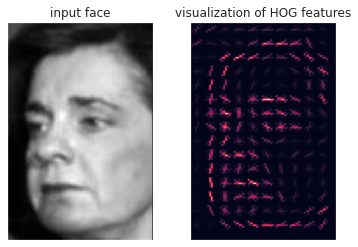

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage import data, color, feature
import skimage.data
import cv2 as cv2

image = cv2.imread('/content/NewDataset/fold_1/face/face_20.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
hog_vec, hog_vis = feature.hog(image, visualize=True)
# hog_vec, hog_vis = feature.hog(image, pixels_per_cell=(64, 64),visualize=True)

# fig, ax = plt.subplots(1, 2, figsize=(12, 6),subplot_kw=dict(xticks=[], yticks=[]))
fig, ax = plt.subplots(1, 2, subplot_kw=dict(xticks=[], yticks=[]))
ax[0].imshow(image, cmap='gray')
# image = cv2.resize(image, dsize=(32,32))
ax[0].set_title('input face')
print('image resize:',image.shape)

ax[1].imshow(hog_vis)
ax[1].set_title('visualization of HOG features');

###5-Training a support vector machine
Using these HOG features, we can build up a simple facial detection algorithm with any Scikit-Learn estimator; here we will use a linear support vector machine (refer back to [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) if you need a refresher on this).
The steps are as follows:

1. Obtain a set of image thumbnails of faces to constitute "positive" training samples.
2. Obtain a set of image thumbnails of non-faces to constitute "negative" training samples.
3. Extract HOG features from these training samples.
4. Train a linear SVM classifier on these samples.
5. For an "unknown" image, pass a sliding window across the image, using the model to evaluate whether that window contains a face or not.
6. If detections overlap, combine them into a single window.

Let's go through these steps and try it out:

#### 5.1 Obtain a set of positive training samples
We have got all positive training samples that show a variety of faces from our previous extacted faces from images.

Input x.shape (3102, 64, 64)
Input y.shape (3102,)
[[ 94  97 104 ... 105 106 106]
 [101 103 109 ... 104 105 106]
 [113 114 116 ... 103 104 105]
 ...
 [177 177 179 ... 104 109 111]
 [185 185 187 ... 121 126 128]
 [190 190 192 ... 131 137 139]]


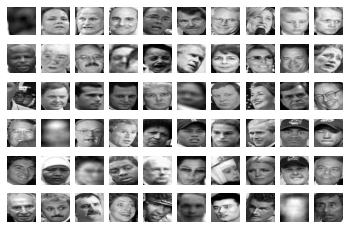

In [ ]:
from sklearn.utils import Bunch

faces=[] 
def ReFileName(dirPath):
    """
    :param dirPath: training face folder path
    :return:
    """
    # Traverse the files in the directory
    for file in os.listdir(dirPath):
        # check if it is a file
        if os.path.isfile(os.path.join(dirPath, file)) == True:
           c= os.path.basename(file)
           name = dirPath + '/' + c
           img = cv2.imread(name)
          #  print(img)
           img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
           img = cv2.resize(img,(64,64))#maek all the size the same
           faces.append(img)
          #  except Exception as e:
          #           print(str(e))


dirPath = r'/content/train/face'
ReFileName(dirPath)
faces=np.array(faces)
print('Input x.shape',faces.shape)
label=[1 for i in range(len(faces))]
label=np.array(label)
print('Input y.shape',label.shape)
print(faces[1])
# plt.imshow(faces[2])
# plt.show()
fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces[50 * i], cmap='gray')
    axi.axis('off')

#### 5.2 Obtain a set of negative training samples

Then we need a set of similarly sized thumbnails which *do not* have a face in them.
One way to do this is to take any corpus of input images, and extract backgrounds thumbnails from them at a variety of scales.

Input x.shape (3101, 64, 64)
Input y.shape (3101,)


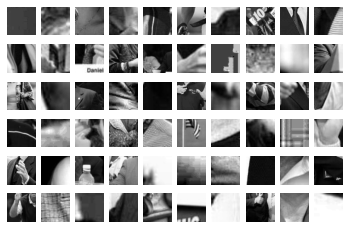

In [ ]:
backgrounds=[] 
def ReFileName(dirPath):
    """
    :param dirPath: training background folder path
    :return:
    """
    # Traverse the files in the directory
    for file in os.listdir(dirPath):
        # check if it is a file
        if os.path.isfile(os.path.join(dirPath, file)) == True:
           c= os.path.basename(file)
           name = dirPath + '/' + c
           img = cv2.imread(name)
          #  print(img)
           img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
           img = cv2.resize(img,dsize=(64,64))#maek all the size the same
           backgrounds.append(img)
          #  except Exception as e:
          #           print(str(e))


dirPath = r'/content/train/background'
ReFileName(dirPath)
backgrounds=np.array(backgrounds)
print('Input x.shape',backgrounds.shape)
label=[1 for i in range(len(backgrounds))]
label=np.array(label)
print('Input y.shape',label.shape)

fig, ax = plt.subplots(6, 10)
for i, axi in enumerate(ax.flat):
    axi.imshow(backgrounds[50 * i], cmap='gray')
    axi.axis('off')

#### 5.3 Combine sets and extract HOG features

Now that we have these balanced positive samples (faces:3102) and negative samples (backgrounds:3101), we can combine them and compute HOG features.
This step takes a little while, because the HOG features involve a nontrivial computation for each image:

In [ ]:
from itertools import chain
X_train = np.array([feature.hog(img)
                    for img in chain(faces,
                                    backgrounds)])
y_train = np.zeros(X_train.shape[0])
y_train[:faces.shape[0]] = 1
X_train.shape

(6203, 2916)

#### 5.4 Fitting a support vector machine
Next we use the tools we have been exploring in this chapter to create a classifier of thumbnail patches. For such a high-dimensional binary classification task, a Linear support vector machine is a good choice. We will use Scikit-Learn's LinearSVC, because in comparison to SVC it often has better scaling for large number of samples.

First, though, let's use a simple Gaussian naive Bayes to get a quick baseline:

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

cross_val_score(GaussianNB(), X_train, y_train)

array([0.91458501, 0.92264303, 0.92989525, 0.92096774, 0.93145161])

We see that on our training data, even a simple Gaussian Naive Bayes algorithm gets us upwards of 90% accuracy. Let's try the support vector machine, with a grid search over a few choices of the C parameter:

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(LinearSVC(loss='squared_hinge',max_iter=2000,C=1.0,verbose=0), {'C': [1.0, 2.0, 4.0, 8.0]})
grid.fit(X_train, y_train)
grid.best_score_

0.9442201918328091

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width = "500" height = "300" alt="图片名称" align=center />
<p>Here is a flowchart of typical cross validation workflow in model training. The best parameters can be determined by grid search techniques.

In [ ]:
grid.best_params_ #the best parameter of C should set to be 1 to retrain model

{'C': 1.0}

Let's take the best estimator and re-train it on the full dataset:

In [ ]:
model = grid.best_estimator_
model.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=2000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

#### 5.5 Find faces in a new image

Now that we have this model in place, let's grab a new image and see how the model does.
We will use one portion of the astronaut image for simplicity (see discussion of this in [Caveats and Improvements](#Caveats-and-Improvements)), and run a sliding window over it and evaluate each patch:

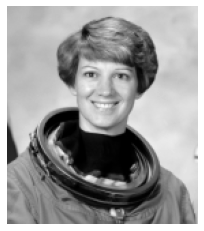

In [ ]:
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

plt.imshow(test_image, cmap='gray')
plt.axis('off');

Next, let's create a window that iterates over patches of this image, and compute HOG features for each patch:

In [ ]:
faces[0].shape

(64, 64)

In [ ]:
def sliding_window(img, patch_size=faces[0].shape,istep=2, jstep=2, scale=1.0):
    Ni, Nj = (int(scale * s) for s in patch_size)
    for i in range(0, img.shape[0] - Ni, istep):
        for j in range(0, img.shape[1] - Ni, jstep):
            patch = img[i:i + Ni, j:j + Nj]
            if scale != 1:
                patch = transform.resize(patch, patch_size)
            yield (i, j), patch
            
indices, patches = zip(*sliding_window(test_image))
patches_hog = np.array([feature.hog(patch) for patch in patches])
patches_hog.shape

(9216, 2916)

Finally, we can take these HOG-featured patches and use our model to evaluate whether each patch contains a face:

In [ ]:
labels = model.predict(patches_hog)
labels.sum()

1267.0

We see that out of nearly 2,000 patches, we have found 30 detections. Let's use the information we have about these patches to show where they lie on our test image, drawing them as rectangles:

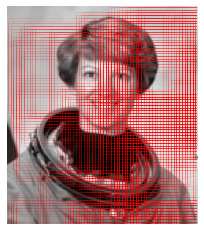

In [ ]:
# test_img = cv2.imread('/content/Dataset/2003/01/01/big/img_158.jpg')
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
fig, ax = plt.subplots()
ax.imshow(test_image, cmap='gray')
ax.axis('off')

Ni, Nj = faces[0].shape
indices = np.array(indices)

for i, j in indices[labels == 1]:
    ax.add_patch(plt.Rectangle((j, i), Nj, Ni, edgecolor='red',
                               alpha=0.1, lw=0.8, facecolor='none'))

###6-Evaluation Performance

### 7-Data Visualization

**Visualize Training curves**

In [ ]:
#=================================
"""### Visualize fitting curve""" 
#================================= 
# for key in history.history:
#     print(key, history.history[key])
plt.figure(figsize=(30, 5), num = 'Metrics')
plt.subplot(121)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('binary_accuracy')
plt.ylabel('val_binary_accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

### 8-Evaluate the Model using Standard Dataset

In [ ]:
#================
# Evaluate Model
#================
score = model.evaluate(test_generator_eval)
print('Test loss:', score[0])
print('Test accuracy', score[1])
#---------------------------------------

In [ ]:
score = model.evaluate(train_generator)
print('Test loss:', score[0])
print('Test accuracy', score[1])


### 9-Prediction

In [ ]:
#================
# Predict Model
#================
prediction = model.predict(test_generator_eval)
#-----------------------------------------

### 10-Visualize Prediction

In [ ]:
#===================================
"""### Visualize the Results"""
#===================================
print('Total number of batches = {}'.format(len(test_generator_eval)))
for n, i in enumerate(test_generator_eval):
    if n >= 1035:
        break
    batch_data = i[0]
# print(batch_data[2])

plt.figure(num='Binary Classification')

plt.subplot('131')
plt.imshow(batch_data[0])
plt.title('Test Image')
plt.axis('off')

plt.subplot('132')
plt.imshow(batch_data[1])
plt.title('Test Image')
plt.axis('off')

plt.subplot('133')
plt.imshow(batch_data[2])
plt.title('Test Image')
plt.axis('off')

plt.show()

### 11-Check predictions

In [ ]:
labels = ['faces','background']
R = 5
C = 5
fig, axes = plt.subplots(R, C, figsize=(14,16))
axes = axes.ravel()

for j in np.arange(0, R*C):
    axes[j].imshow(batch_data[j])
    axes[j].set_title("True: %s \nPredict: %s" % (labels[y_True[j]], labels[prediction[j]]))
    axes[j].axis('off')
    plt.subplots_adjust(wspace=1)

### 12-Check wrong predictions

In [ ]:
R = 1
C = 5
fig, axes = plt.subplots(R, C, figsize=(12,8))
axes = axes.ravel()

misclassified_idx = np.where(prediction != y_True)[0]
for k in np.arange(0, R*C):
    axes[k].imshow(batch_data[misclassified_idx[k]])
    axes[k].set_title("True: %s \nPredicted: %s" % (labels[y_True[misclassified_idx[k]]], 
                                                  labels[prediction[misclassified_idx[k]]]))
    axes[k].axis('off')
    plt.subplots_adjust(wspace=1)

### 13-Metrics

### ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds  = roc_curve(test_generator_eval.classes, prediction)
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, label='Random guess',linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# # Sensitivity
# recall = tpr

# # Specificity
# specificity = 1 - fpr


### Other Metrics

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
# Threshold Prediction
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

prediction[prediction< optimal_threshold] = 0
prediction[prediction>= optimal_threshold] = 1
prediction = (prediction.ravel()).astype(int)
# Get Y_GroundTruth
y_True = (np.expand_dims(test_generator_eval.classes, axis=1).ravel()).astype(int)
print("groundtruth:",y_True[:35])
print("predictions:",prediction[:35])
# Get Metrics
Metrics = precision_recall_fscore_support(y_True, prediction)
Metrics1 = classification_report(y_True, prediction,labels=None, target_names=['face','background'],output_dict=False,zero_division='warn')
# accuracy = Metrics1['accuracy']
# print(accuracy)
print("---------classification_report-------------------")
print(Metrics1)
# print(len(Metrics))
# print(Metrics[0],Metrics[1])
# ----------------------------
Accuracy = (y_True.shape - np.sum(np.bitwise_xor(y_True, prediction))) / y_True.shape
Precision = np.round(min(Metrics[0]),2)
Recall = np.round(min(Metrics[1]),2)
F1_Score = (2*Precision*Recall)/(Precision+Recall)
print("-----------calculate by hand-----------------")
print("Accuracy= ", Accuracy,"\nPrecision= ", Precision, "\nRecall= ", Recall, "\nF1_Score= ", F1_Score)



* The precision will be "how many are correctly classified among that class"
* The recall means "how many of this class you find over the whole number of element of this class"
* The f1-score is the harmonic mean between precision & recall。
* The support is the number of occurence of 
the given class in your dataset (so you have 1035 of class 0 and 1035 of class 1, which is a really well balanced dataset.

In [ ]:
%cd /content/train/face
!ls -l | grep "^-" | wc -l
%cd /content/train/face
!ls -l | grep "^-" | wc -l

%cd /content/valid/face
!ls -l | grep "^-" | wc -l
%cd /content/valid/background/
!ls -l | grep "^-" | wc -l

%cd /content/test/face
!ls -l | grep "^-" | wc -l

%cd /content/test/background/
!ls -l | grep "^-" | wc -l

### Confusion Matrix

In [ ]:
from sklearn import metrics
conf = metrics.confusion_matrix(y_True, prediction)
conf

In [ ]:
import itertools
classes = ['face', 'background']
# plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix: N(Test_set)={len(y_True)")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

### Normalized confusion matrix

In [ ]:
# confusion matrix
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix
plot_confusion_matrix(y_True, prediction,
                      figsize=(6,4),
                      title=f'Confusion Matrix: N(Test_set)={len(y_True)}',
                      normalize=True);  

### Accuracy 
number of examples correctly predicted / total number of examples  
![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/c72ec21ef2505c2d376e96197637fc64f75e5891)

In [ ]:
from sklearn import metrics
conf = metrics.confusion_matrix(y_True, prediction)
conf

In [ ]:
# from the confusion matrix
TP = true_pos = 937
TN = true_neg = 951
FP = false_pos = 98
FN = false_neg = 84
results = {}
metric = "ACC"

results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} is {results[metric]: .3f}")

In [ ]:
from sklearn.metrics import classification_report
target_names = ['face', 'background']
print(classification_report(y_True, prediction, target_names=target_names))

In [ ]:
y_true = [1, 1, 1]
y_pred = [1, 1, 0] #predicted rightly 2

conf = metrics.confusion_matrix(y_true, y_pred)
print(conf)
print(classification_report(y_true, y_pred))

tp=0
tn=0
fn=1
fp=2

acc=(tp+fp)/(tp+tn+fn+fp)
print(acc)